# Simple L-System for Space Engineers

Uses the PCGSEPy library included in this repository.

**NOTE**: Have the game *running*; leaving the game simply paused breaks the API (no calls are accepted). *Suggestion*: Use windowed mode, press `Start` after the scenario is loaded and return to this notebook.

Import required packages

In [1]:
import numpy as np

from enum import Enum, auto
from typing import List, Dict, Any

from pcgsepy.common.api_call import GameMode, get_base_values, toggle_gamemode
from pcgsepy.structure import *

## Simple L-system

A simple L-system to generate a structure using rules.

Strings used as high-level structure:
- `cockpit`
- `engine`
- `corridor`
- `thruster`
- etc...

Strings used to define blocks:
- *See `block_definitions.json` for a full list*.

Strings used to define rotation commands:
- `rotXcwY`: Clockwise rotation from X to Y
- `rotXcwZ`: Clockwise rotation from X to Z
- `rotYcwX`: Clockwise rotation from Y to X 
- `rotYcwZ`: Clockwise rotation from Y to Z 
- `rotZcwX`: Clockwise rotation from Z to X 
- `rotZcwY`: Clockwise rotation from Z to Y 
- `rotXccwY`: Counter-clockwise rotation from X to Y 
- `rotXccwZ`: Counter-clockwise rotation from X to Z  
- `rotYccwX`: Counter-clockwise rotation from Y to X  
- `rotYccwZ`: Counter-clockwise rotation from Y to Z  
- `rotZccwX`: Counter-clockwise rotation from Z to X  
- `rotZccwY`: Counter-clockwise rotation from Z to Y   

Characters used as actions:
- `[` and `]`]: Push and pop current coordinate
- `+`: Move forward along `x`
- `-`: Move backward along `x`
- `!`: Move forward along `y`
- `?`: Move backward along `y`
- `>`: Move forward along `z`
- `<`: Move backward along `z`

### L Parser class.

Expansion and production methods transform the initial axiom using the provided rules for a number `n` of iterations.

**NOTE**: Rules can have multiple characters in the *RHS*, which allows for more complex axioms. Rules are stochastic (i.e.: $LHS \rightarrow p(RHS | LHS)$); to make a rule deterministic simply use a single $LHS \rightarrow RHS$ with $p=1.$.

In [2]:
class StochasticRules:
    def __init__(self):
        self._rules = {}
    
    def add_rule(self,
                 lhs: str,
                 rhs: str,
                 p: float) -> None:
        if lhs in self._rules.keys():
            self._rules[lhs][0].append(rhs)
            self._rules[lhs][1].append(p)
        else:
            self._rules[lhs] = ([rhs], [p])
    
    def rem_rule(self,
                 lhs: str) -> None:
        self._rules.pop(lhs)
    
    def get_lhs(self) -> List[str]:
        return self._rules.keys()
    
    def get_rhs(self,
                lhs: str) -> str:
        rhs, p = self._rules[lhs]
        return np.random.choice(rhs, p=p)
    
    def validate(self):
        for lhs in self._rules.keys():
            p = sum(self._rules[lhs][1])
            assert np.isclose(p, 1.), f'Probability must sum to 1: found {p} for `{lhs}`.'


class LParser:
    def __init__(self,
                 rules: StochasticRules):
        self.rules = rules

    def _expand(self,
                axiom: str) -> str:
        i = 0
        while i < len(axiom):
            for k in self.rules.get_lhs():
                if axiom[i:].startswith(k):
                    rhs = self.rules.get_rhs(k)
                    axiom = axiom[:i] + rhs + axiom[i + len(k):]
                    i += len(rhs) - 1  # since we use multiple characters in LHS, we need to skip them in the current iteration
                    break
            i += 1
        return axiom

    def produce(self,
                axiom: str,
                n: int) -> str:
        for _ in range(n):
            axiom = self._expand(axiom=axiom)
        return axiom

### Solver class

The `Solver` can both solve for a given axiom and fill a `Structure` with an axiom.

Mapping axiom atoms to `Structure` interactions:

In [62]:
class AtomAction(Enum):
    PLACE = auto()
    MOVE = auto()
    PUSH = auto()
    ROTATE = auto()
    POP = auto()

# Note: some of this stuff can be moved to the common library (such as rotations)
class Rotations(Enum):
    XcwY = auto()
    XcwZ = auto()
    YcwX = auto()
    YcwZ = auto()
    ZcwX = auto()
    ZcwY = auto()
    XccwY = auto()
    XccwZ = auto()
    YccwX = auto()
    YccwZ = auto()
    ZccwX = auto()
    ZccwY = auto()

atoms_alphabet = {    
    '+': {'action': AtomAction.MOVE,
          'args': Orientation.RIGHT},
    '-': {'action': AtomAction.MOVE,
          'args': Orientation.LEFT},
    '!': {'action': AtomAction.MOVE,
          'args': Orientation.UP},
    '?': {'action': AtomAction.MOVE,
          'args': Orientation.DOWN},
    '>': {'action': AtomAction.MOVE,
          'args': Orientation.FORWARD},
    '<': {'action': AtomAction.MOVE,
          'args': Orientation.BACKWARD},
    
    'RotXcwY': {'action': AtomAction.ROTATE,
              'args': Rotations.XcwY},
    'RotXcwZ': {'action': AtomAction.ROTATE,
              'args': Rotations.XcwZ},
    'RotYcwX': {'action': AtomAction.ROTATE,
              'args': Rotations.YcwX},
    'RotYcwZ': {'action': AtomAction.ROTATE,
              'args': Rotations.YcwZ},
    'RotZcwX': {'action': AtomAction.ROTATE,
              'args': Rotations.ZcwX},
    'RotZcwY': {'action': AtomAction.ROTATE,
              'args': Rotations.ZcwY},
    'RotXccwY': {'action': AtomAction.ROTATE,
              'args': Rotations.XccwY},
    'RotXccwZ': {'action': AtomAction.ROTATE,
              'args': Rotations.XccwZ},
    'RotYccwX': {'action': AtomAction.ROTATE,
              'args': Rotations.YccwX},
    'RotYccwZ': {'action': AtomAction.ROTATE,
              'args': Rotations.YccwZ},
    'RotZccwX': {'action': AtomAction.ROTATE,
              'args': Rotations.ZccwX},
    'RotZccwY': {'action': AtomAction.ROTATE,
              'args': Rotations.ZccwY},
    
    '[': {'action': AtomAction.PUSH,
          'args': []},
    ']': {'action': AtomAction.POP,
          'args': []}
}

with open('./block_definitions.json', 'r') as f:
    block_definitions = json.load(f)
    for k in block_definitions.keys():
        if k != '':
            atoms_alphabet[k] = {'action': AtomAction.PLACE,
                                 'args': [k]}

orientations_ids = {
    'U': Orientation.UP,
    'D': Orientation.DOWN,
    'L': Orientation.LEFT,
    'R': Orientation.RIGHT,
    'F': Orientation.FORWARD,
    'B': Orientation.BACKWARD
}

In [63]:
# Note: This can definitely be simplified, but for now it *works*
_rotate_orientations = {
    Orientation.UP: {
        Rotations.XcwY: Orientation.RIGHT,
        Rotations.XccwY: Orientation.LEFT,
        Rotations.XcwZ: Orientation.UP,
        Rotations.XccwZ: Orientation.UP,
        Rotations.YcwX: Orientation.RIGHT, 
        Rotations.YccwX: Orientation.LEFT,
        Rotations.YcwZ: Orientation.BACKWARD,
        Rotations.YccwZ: Orientation.FORWARD,
        Rotations.ZcwX: Orientation.UP,
        Rotations.ZccwX: Orientation.UP,
        Rotations.ZcwY: Orientation.BACKWARD,
        Rotations.ZccwY: Orientation.FORWARD
    },
    Orientation.DOWN: {
        Rotations.XcwY: Orientation.LEFT,
        Rotations.XccwY: Orientation.RIGHT,
        Rotations.XcwZ: Orientation.DOWN,
        Rotations.XccwZ: Orientation.DOWN,
        Rotations.YcwX: Orientation.LEFT, 
        Rotations.YccwX: Orientation.RIGHT,
        Rotations.YcwZ: Orientation.FORWARD,
        Rotations.YccwZ: Orientation.BACKWARD,
        Rotations.ZcwX: Orientation.DOWN,
        Rotations.ZccwX: Orientation.DOWN,
        Rotations.ZcwY: Orientation.FORWARD,
        Rotations.ZccwY: Orientation.BACKWARD
    },
    Orientation.LEFT: {
        Rotations.XcwY: Orientation.UP,
        Rotations.XccwY: Orientation.DOWN,
        Rotations.XcwZ: Orientation.BACKWARD,
        Rotations.XccwZ: Orientation.FORWARD,
        Rotations.YcwX: Orientation.UP, 
        Rotations.YccwX: Orientation.DOWN,
        Rotations.YcwZ: Orientation.LEFT,
        Rotations.YccwZ: Orientation.LEFT,
        Rotations.ZcwX: Orientation.FORWARD,
        Rotations.ZccwX: Orientation.BACKWARD,
        Rotations.ZcwY: Orientation.LEFT,
        Rotations.ZccwY: Orientation.LEFT
    },
    Orientation.RIGHT: {
        Rotations.XcwY: Orientation.DOWN,
        Rotations.XccwY: Orientation.UP,
        Rotations.XcwZ: Orientation.FORWARD,
        Rotations.XccwZ: Orientation.BACKWARD,
        Rotations.YcwX: Orientation.DOWN, 
        Rotations.YccwX: Orientation.UP,
        Rotations.YcwZ: Orientation.RIGHT,
        Rotations.YccwZ: Orientation.RIGHT,
        Rotations.ZcwX: Orientation.BACKWARD,
        Rotations.ZccwX: Orientation.FORWARD,
        Rotations.ZcwY: Orientation.RIGHT,
        Rotations.ZccwY: Orientation.RIGHT
    },
    Orientation.FORWARD: {
        Rotations.XcwY: Orientation.FORWARD,
        Rotations.XccwY: Orientation.FORWARD,
        Rotations.XcwZ: Orientation.RIGHT,
        Rotations.XccwZ: Orientation.LEFT,
        Rotations.YcwX: Orientation.FORWARD, 
        Rotations.YccwX: Orientation.FORWARD,
        Rotations.YcwZ: Orientation.DOWN,
        Rotations.YccwZ: Orientation.UP,
        Rotations.ZcwX: Orientation.RIGHT,
        Rotations.ZccwX: Orientation.LEFT,
        Rotations.ZcwY: Orientation.UP,
        Rotations.ZccwY: Orientation.DOWN
    },
    Orientation.BACKWARD: {
        Rotations.XcwY: Orientation.BACKWARD,
        Rotations.XccwY: Orientation.BACKWARD,
        Rotations.XcwZ: Orientation.LEFT,
        Rotations.XccwZ: Orientation.RIGHT,
        Rotations.YcwX: Orientation.BACKWARD, 
        Rotations.YccwX: Orientation.BACKWARD,
        Rotations.YcwZ: Orientation.UP,
        Rotations.YccwZ: Orientation.DOWN,
        Rotations.ZcwX: Orientation.LEFT,
        Rotations.ZccwX: Orientation.RIGHT,
        Rotations.ZcwY: Orientation.DOWN,
        Rotations.ZccwY: Orientation.UP
    }
}

def rotate_orientation(o: Orientation,
                       rs: List[Rotations]) -> Orientation:
    for r in rs:
        o = _rotate_orientations[o][r]
    return o

In [70]:
class LSolver:
    def __init__(self,
                 atoms_alphabet: Dict[str, Dict[AtomAction, Any]],
                 parser: LParser):
        self.atoms_alphabet = atoms_alphabet
        self.parser = parser
        # self.atoms_alphabet.pop('')  # bugfix but doesn't make much sense to be here in the first place
    
    def solve(self,
              axiom: str,
              iterations: int) -> str:
        return self.parser.produce(axiom=axiom,
                                   n=iterations)
    
    class _ProcessData:
        def __init__(self,
                     position: Vec,
                     structure: Structure):
            self.position = position
            self.rotations = []
            self.position_history = []
            self.structure = structure
            # temporary, used only when extracting properties
            # (which will need a rework)
            self.a = ''
            self.i = 0
            self.axiom = ''
    
    def _rotate(self,
                data: _ProcessData,
                action_args: Any) -> int:
        data.rotations.append(action_args)
        return 0
    
    def _move(self,
              data: _ProcessData,
              action_args: Any) -> int:
        if data.rotations:
            action_args = rotate_orientation(action_args,
                                             data.rotations)
        data.position = data.position.sum(action_args.value)
        return 0
    
    def _push(self,
              data: _ProcessData,
              action_args: Any) -> int:
        data.position_history.append(data.position)
        return 0
    
    def _pop(self,
             data: _ProcessData,
             action_args: Any) -> int:
        data.position = data.position_history.pop(-1)
        if data.rotations:
            data.rotations.pop(-1)
        return 0
    
    def _place(self,
               data: _ProcessData,
               action_args: Any) -> int:
        orientation_forward, orientation_up = data.axiom[data.i + len(data.a):data.i + len(data.a) + 2]
        # print(action_args, data.i, data.a, orientation_forward, orientation_up)
        orientation_forward = orientations_ids[orientation_forward]
        orientation_up = orientations_ids[orientation_up]
        if data.rotations:
            orientation_forward = rotate_orientation(orientation_forward, data.rotations)
            orientation_up = rotate_orientation(orientation_up, data.rotations)
        data.structure.add_block(block=Block(block_type=action_args[0],
                                             orientation_forward=orientation_forward,
                                             orientation_up=orientation_up),
                                 grid_position=data.position.as_tuple())
        return 2
    
    _calls = {
        AtomAction.PLACE: _place,
        AtomAction.MOVE: _move,
        AtomAction.ROTATE: _rotate,
        AtomAction.PUSH: _push,
        AtomAction.POP: _pop
    }
        
    # Note: this method is a bit of a spaghetti code, could use some improvement
    def fill_structure(self,
                       structure: Structure,
                       axiom: str) -> None:
        data = self._ProcessData(position=structure.starting_coords,
                                 structure=structure)
        data.axiom = axiom
        i = 0
        while i < len(axiom):
            for a in self.atoms_alphabet.keys():
                if axiom.startswith(a, i):
                    data.i = i
                    data.a = a
                    action, args = self.atoms_alphabet[a]['action'], self.atoms_alphabet[a]['args']
                    i += self._calls[action](self, data, args)
                    if data.position.largest_dim() > min(structure.dimensions):
                        raise Exception('Unable to fully fill structure.')
                    i += len(a)
                    break

### Rule maker

Read a configuration file with the rules and create the Rule object.

In [71]:
class RuleMaker:
    def __init__(self,
                 ruleset: str):
        with open(ruleset, 'r') as f:
            self.ruleset = f.readlines()
    
    def get_rules(self) -> StochasticRules:
        rules = StochasticRules()
        for rule in self.ruleset:
            if rule.startswith('#'):  # comment in configuration file
                pass
            else:
                lhs, p, rhs = rule.strip().split(' ')
                rules.add_rule(lhs=lhs,
                               rhs=rhs,
                               p=float(p))
        rules.validate()
        return rules

## L-System

Populate different structures with L-system solutions at different iterations.

In [72]:
class LSystem:
    def __init__(self,
                 hl_rules: str,
                 ll_rules: str,
                 alphabet: Dict[str, any]):
        self.hl_rules = RuleMaker(ruleset=hl_rules).get_rules()
        self.ll_rules = RuleMaker(ruleset=ll_rules).get_rules()
        self.hl_parser = LParser(rules=self.hl_rules)
        self.ll_parser = LParser(rules=self.ll_rules)
        self.solver = LSolver(atoms_alphabet=alphabet,
                              parser=self.ll_parser)
    
    def apply_rules(self,
                    starting_axiom: str,
                    structure_dims: Tuple[int, int, int],
                    iterations: int = 1,
                    make_graph: bool = False) -> Structure:
        base_position, orientation_forward, orientation_up = Vec.v3f(0., 0., 0.), Orientation.FORWARD.value, Orientation.UP.value
        structure = Structure(origin=base_position,
                              orientation_forward=orientation_forward,
                              orientation_up=orientation_up,
                              dimensions=structure_dims)
        hl_axiom = self.hl_parser.produce(axiom=starting_axiom,
                                          n=iterations)
        print(f'Abstract axiom:\n\t{hl_axiom}')
        ll_axiom = self.solver.solve(axiom=hl_axiom,
                                     iterations=1)        
        print(f'Block axiom:\n\t{ll_axiom}')
               
        self.solver.fill_structure(structure=structure,
                                   axiom=ll_axiom)
        if make_graph:
            plot_structure(structure=structure,
                           title=hl_axiom,
                           axis_limits=structure_dims)
        
        return structure

Abstract axiom:
	cockpitcorridorcorridor?????RotZcwY[corridorthruster]!!!!!corridor?????RotZcwY[corridor]!!!!!corridorcorridor
Block axiom:
	LargeBlockArmorBlockFU+++++LargeBlockArmorBlockFU!!!!!LargeBlockCockpitFU?????+++++LargeBlockArmorBlockFU!!!!!LargeBlockArmorBlockFU!!!!!LargeBlockArmorBlockFU-----LargeBlockArmorBlockFU-----LargeBlockArmorBlockFU?????LargeBlockArmorBlockFU?????<<<<<LargeBlockArmorBlockFU+++++LargeBlockArmorBlockFU+++++LargeBlockArmorBlockFU!!!!!LargeBlockArmorBlockFU!!!!!LargeBlockArmorBlockFU-----LargeBlockArmorBlockFU-----LargeBlockArmorBlockFU?????LargeBlockArmorBlockFU?????<<<<<LargeBlockArmorSlopeUL+++++LargeBlockArmorBlockFU+++++LargeBlockArmorSlopeUR!!!!!LargeBlockArmorBlockFU!!!!!LargeBlockArmorSlopeDR-----LargeBlockArmorBlockFU-----LargeBlockArmorSlopeDL?????LargeBlockArmorBlockFU?????<<<<<?????RotZcwY[LargeBlockArmorSlopeUL+++++LargeBlockArmorBlockFU+++++LargeBlockArmorSlopeUR!!!!!LargeBlockArmorBlockFU!!!!!LargeBlockArmorSlopeDR-----LargeBlockArmorBloc

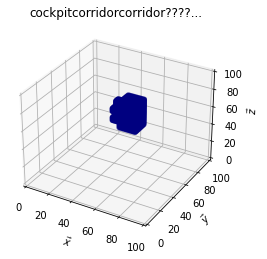

In [77]:
lsystem = LSystem(hl_rules='hlrules',
                  ll_rules='llrules',
                  alphabet=atoms_alphabet)

structure = lsystem.apply_rules(starting_axiom='begin',
                                structure_dims=(100,100,100),
                                iterations=4,
                                make_graph=True)

### Game interaction

Place structure in-game by updating its position and rotation according to the player.

In [78]:
if True:
    base_position, orientation_forward, orientation_up = get_base_values()
    # orientation_forward = Orientation.FORWARD
    # orientation_up = Orientation.UP
    structure.update(origin=base_position,
                     orientation_forward=orientation_forward,
                     orientation_up=orientation_up)
    toggle_gamemode(GameMode.PLACING)
    place_blocks(structure.get_all_blocks(), False)
    toggle_gamemode(GameMode.EVALUATING)

In [ ]:
# jsons = [ 
#         generate_json(method="Observer.ObserveBlocks")
#         ]
# call_api(jsons=jsons)